In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm, expon, gamma, skewnorm
import os.path
from sklearn.cluster import AgglomerativeClustering, SpectralBiclustering, SpectralCoclustering
from mpl_toolkits.mplot3d import Axes3D

import IPython

import sys
sys.setrecursionlimit(10000)

from configMaker import get_model_name

#dataset_type = 'cifar10'
dataset_type = 'mnist_small'
model_type = 'all_cnn_c_hidden'
#out = '../output-week4'
out = '../output-week3'
#nametag = 'find-distribs-deeper'
nametag = 'find_distribs'

if dataset_type == 'mnist_small':
    seeds = range(300)
    num_steps = 300000
    num_train_points = 5500
    num_units = 2
elif dataset_type == 'mnist':
    seeds = range(8)
    num_steps = 1000000
    num_train_points = 55000
    num_units = 3
elif dataset_type == 'cifar10_small':
    seeds = range(1)
    num_steps = 300000
    num_train_points = 4900
    num_units = 2
elif dataset_type == 'cifar10':
    seeds = range(24)
    num_steps = 1000000
    num_train_points = 49000
    num_units = 3
num_test_points = 10000
num_seeds = len(seeds)

test_idx=6558

fontsize=16
sns.set(color_codes=True)
sns.set_style('white')

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def get_inverse_hvp(idx):
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seeds[idx], num_units=num_units, num_steps=num_steps)
    f = np.load('../{}/{}-cg-normal_loss-test-{}.npz'.format(out,model_name,[test_idx]))
    return f['inverse_hvp']
inverse_hvps = [None] * num_seeds
for i in range(num_seeds):
    inv = get_inverse_hvp(i)
    inverse_hvps[i] = []
    for arr in inv:
        inverse_hvps[i] = list(inverse_hvps[i]) + list(arr)
inverse_hvps = np.array(inverse_hvps)

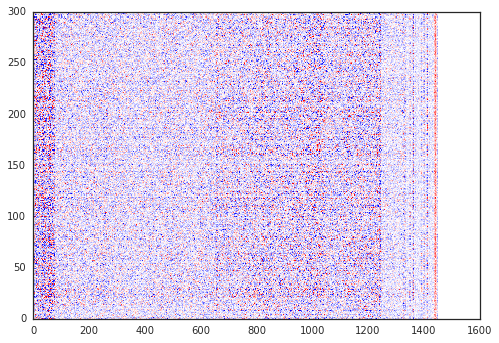

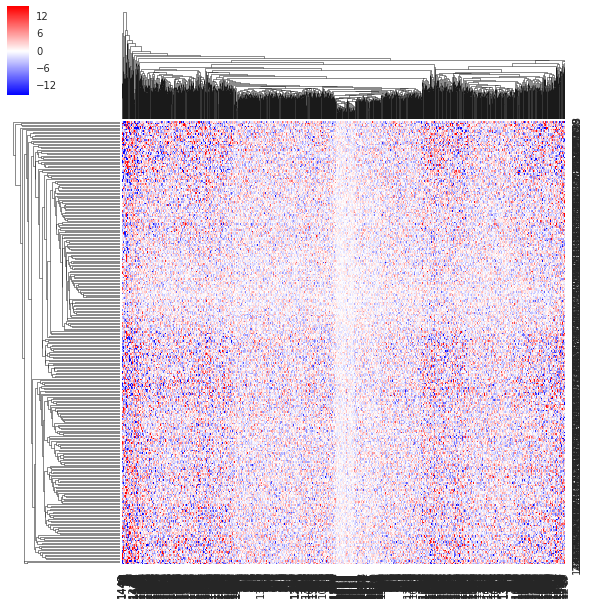

In [18]:
plt.pcolormesh(inverse_hvps,cmap=plt.cm.bwr,norm=colors.Normalize(inverse_hvps.min()/5,inverse_hvps.max()/5))
plt.show()
g = sns.clustermap(inverse_hvps,method='complete',cmap='bwr',vmin=inverse_hvps.min()/5,vmax=inverse_hvps.max()/5)

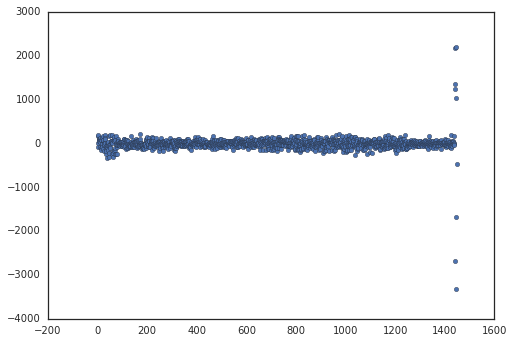

In [130]:
plt.scatter(range(1448),np.sum(inverse_hvps, axis=0))

In [26]:
def get_train_grad_loss_vals_for_seed(seed):
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type,
                                seed=seed, num_units=num_units, num_steps=num_steps)
    f = np.load('../{}/{}_{}-seed_all_train_grad_loss_vals.npz'.format(out, model_name, seed))
    arr = f['train_grad_loss_vals']
    flat_arr = [None] * len(arr)
    for i, elem in enumerate(arr):
        flat_arr[i] = np.concatenate(elem)
    return np.array(flat_arr)

def scaled_norm_2(x,y):
    return np.linalg.norm(np.multiply(x,y))**2

def add_noise_for_seed(seed, fraca, fracb, multa, multb, ntype='proportional', show_noise=False):
    a = inverse_hvps[seed]
    if ntype == 'proportional':
        sa = np.abs(np.divide(np.mean(inverse_hvps, axis=0), fraca))
    else:
        sa = np.array([ntype[0]] * len(a))
    
    if show_noise:
        plt.plot(a)
        plt.show()
        plt.plot(sa)
        plt.show()
    
    train_grad_loss_vals_seed = get_train_grad_loss_vals_for_seed(seed)
    if ntype == 'proportional':
        sb = np.abs(np.divide(np.mean(train_grad_loss_vals_seed, axis=0), fracb))
    else:
        sb = np.array([ntype[1]] * len(train_grad_loss_vals_seed[0]))
    m = np.zeros(num_train_points,dtype=np.float32)
    v = np.zeros(num_train_points,dtype=np.float32)
    v_mult = np.zeros(num_train_points,dtype=np.float32)
    v_comb = np.zeros(num_train_points,dtype=np.float32)
    
    if show_noise:
        plt.plot(train_grad_loss_vals_seed[0])
        plt.show()
        plt.plot(sb)
        plt.show()
    
    for i in range(num_train_points):
        b = train_grad_loss_vals_seed[i]
        m[i] = np.dot(a,b) / num_train_points
        v[i] = scaled_norm_2(a, sb) + scaled_norm_2(b, sa) + scaled_norm_2(sa, sb)
        v_mult[i] = (m[i] ** 2) * ((multa)**2 + (multb)**2 + (multa)**2 * (multb)**2)
        v_comb[i] = v_mult[i] + (1+multb**2)*scaled_norm_2(b, sa) +\
                (1+multa**2)*scaled_norm_2(a, sb) + scaled_norm_2(sa, sb)
    
    plt.scatter(m, np.sqrt(v), alpha=0.3)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 150)
    y = scaled_norm_2(sa, sb) + (2 * np.max(np.multiply(sa, sb)) * np.abs(x))
    plt.plot(x, np.sqrt(y))
    plt.xlabel('Simulated mean')
    plt.ylabel('Simulated stddev')
    if ntype == 'proportional':
        plt.suptitle('Seed {}, 1/{} and 1/{} additive noise'.format(seed, fraca, fracb))
    else:
        plt.suptitle('Seed {}, {} and {} constant additive noise'.format(seed, ntype[0], ntype[1]))
    plt.show()
    
    indices = np.greater(np.sqrt(v),[0.0001]*len(v))
    plt.suptitle('Angle wrt y-axis')
    plt.xlabel('Radians')
    plt.ylabel('Count')
    plt.hist(np.arctan(np.divide(m[np.where(indices)[0]],np.sqrt(v[np.where(indices)[0]]))),bins=30)#,range=(-2,2))
    plt.show()
    
    plt.scatter(m, np.sqrt(v_mult), alpha=0.3)
    plt.xlabel('Simulated mean')
    plt.ylabel('Simulated stddev')
    plt.suptitle('Seed {}, {} and {} multiplicative noise'.format(seed, multa, multb))
    plt.show()

    plt.figure(figsize=(5,5),dpi=400)
    plt.scatter(m, np.sqrt(v_comb), alpha=0.3)
    plt.xlabel('Simulated Mean',fontsize=20)
    plt.xlim(-0.03,0.055)
    plt.xticks([-0.02,0,0.02,0.04])
    plt.ylabel('Simulated Stddev',fontsize=20)
    plt.ylim(-0.005,0.035)    
    plt.savefig('MNIST_sim_pred_infl.png',dpi=400)
    """if ntype == 'proportional':
        plt.suptitle('Seed {}, 1/{} and 1/{} additive noise, {} and {} multiplicative noise'.format(
            seed, fraca, fracb, multa, multb))
    else:
        plt.suptitle('Seed {}, {} and {} constant additive noise, {} and {} multiplicative noise'.format(
            seed, ntype[0], ntype[1], multa, multb))"""
    plt.show()
        
    indices = np.greater(np.sqrt(v_comb),[0.0001]*len(v))
    plt.suptitle('Angle wrt y-axis')
    plt.xlabel('Radians')
    plt.ylabel('Count')
    plt.hist(np.arctan(np.divide(m[np.where(indices)[0]],np.sqrt(v_comb[np.where(indices)[0]]))),bins=30)#,range=(-2,2))
    plt.show()


#add_noise_for_seed(0, 2400, 1024, 0.4, 0.4)#, ntype=(0.0001,0.000001))
#add_noise_for_seed(0, 1024, 1024, 0.2, 0.2)#, ntype=(0.00005,0.0000005))
#add_noise_for_seed(0, 1024, 1024, 0.2, 0.2)#, ntype=(0.00005,0.000001))
#add_noise_for_seed(0, 1024, 1024, 0.2, 0.2)#, ntype=(0.0001,0.0000005))

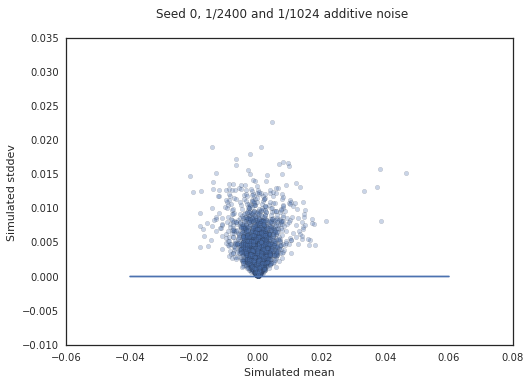

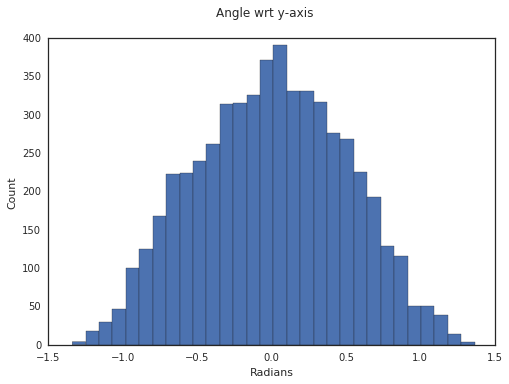

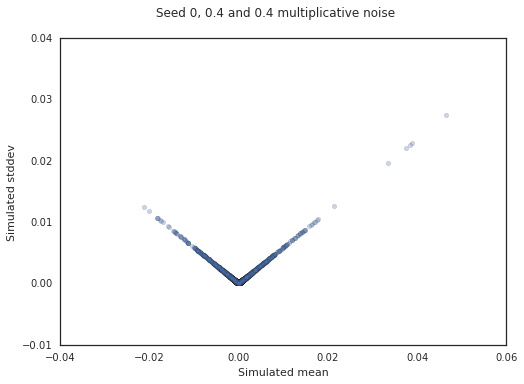

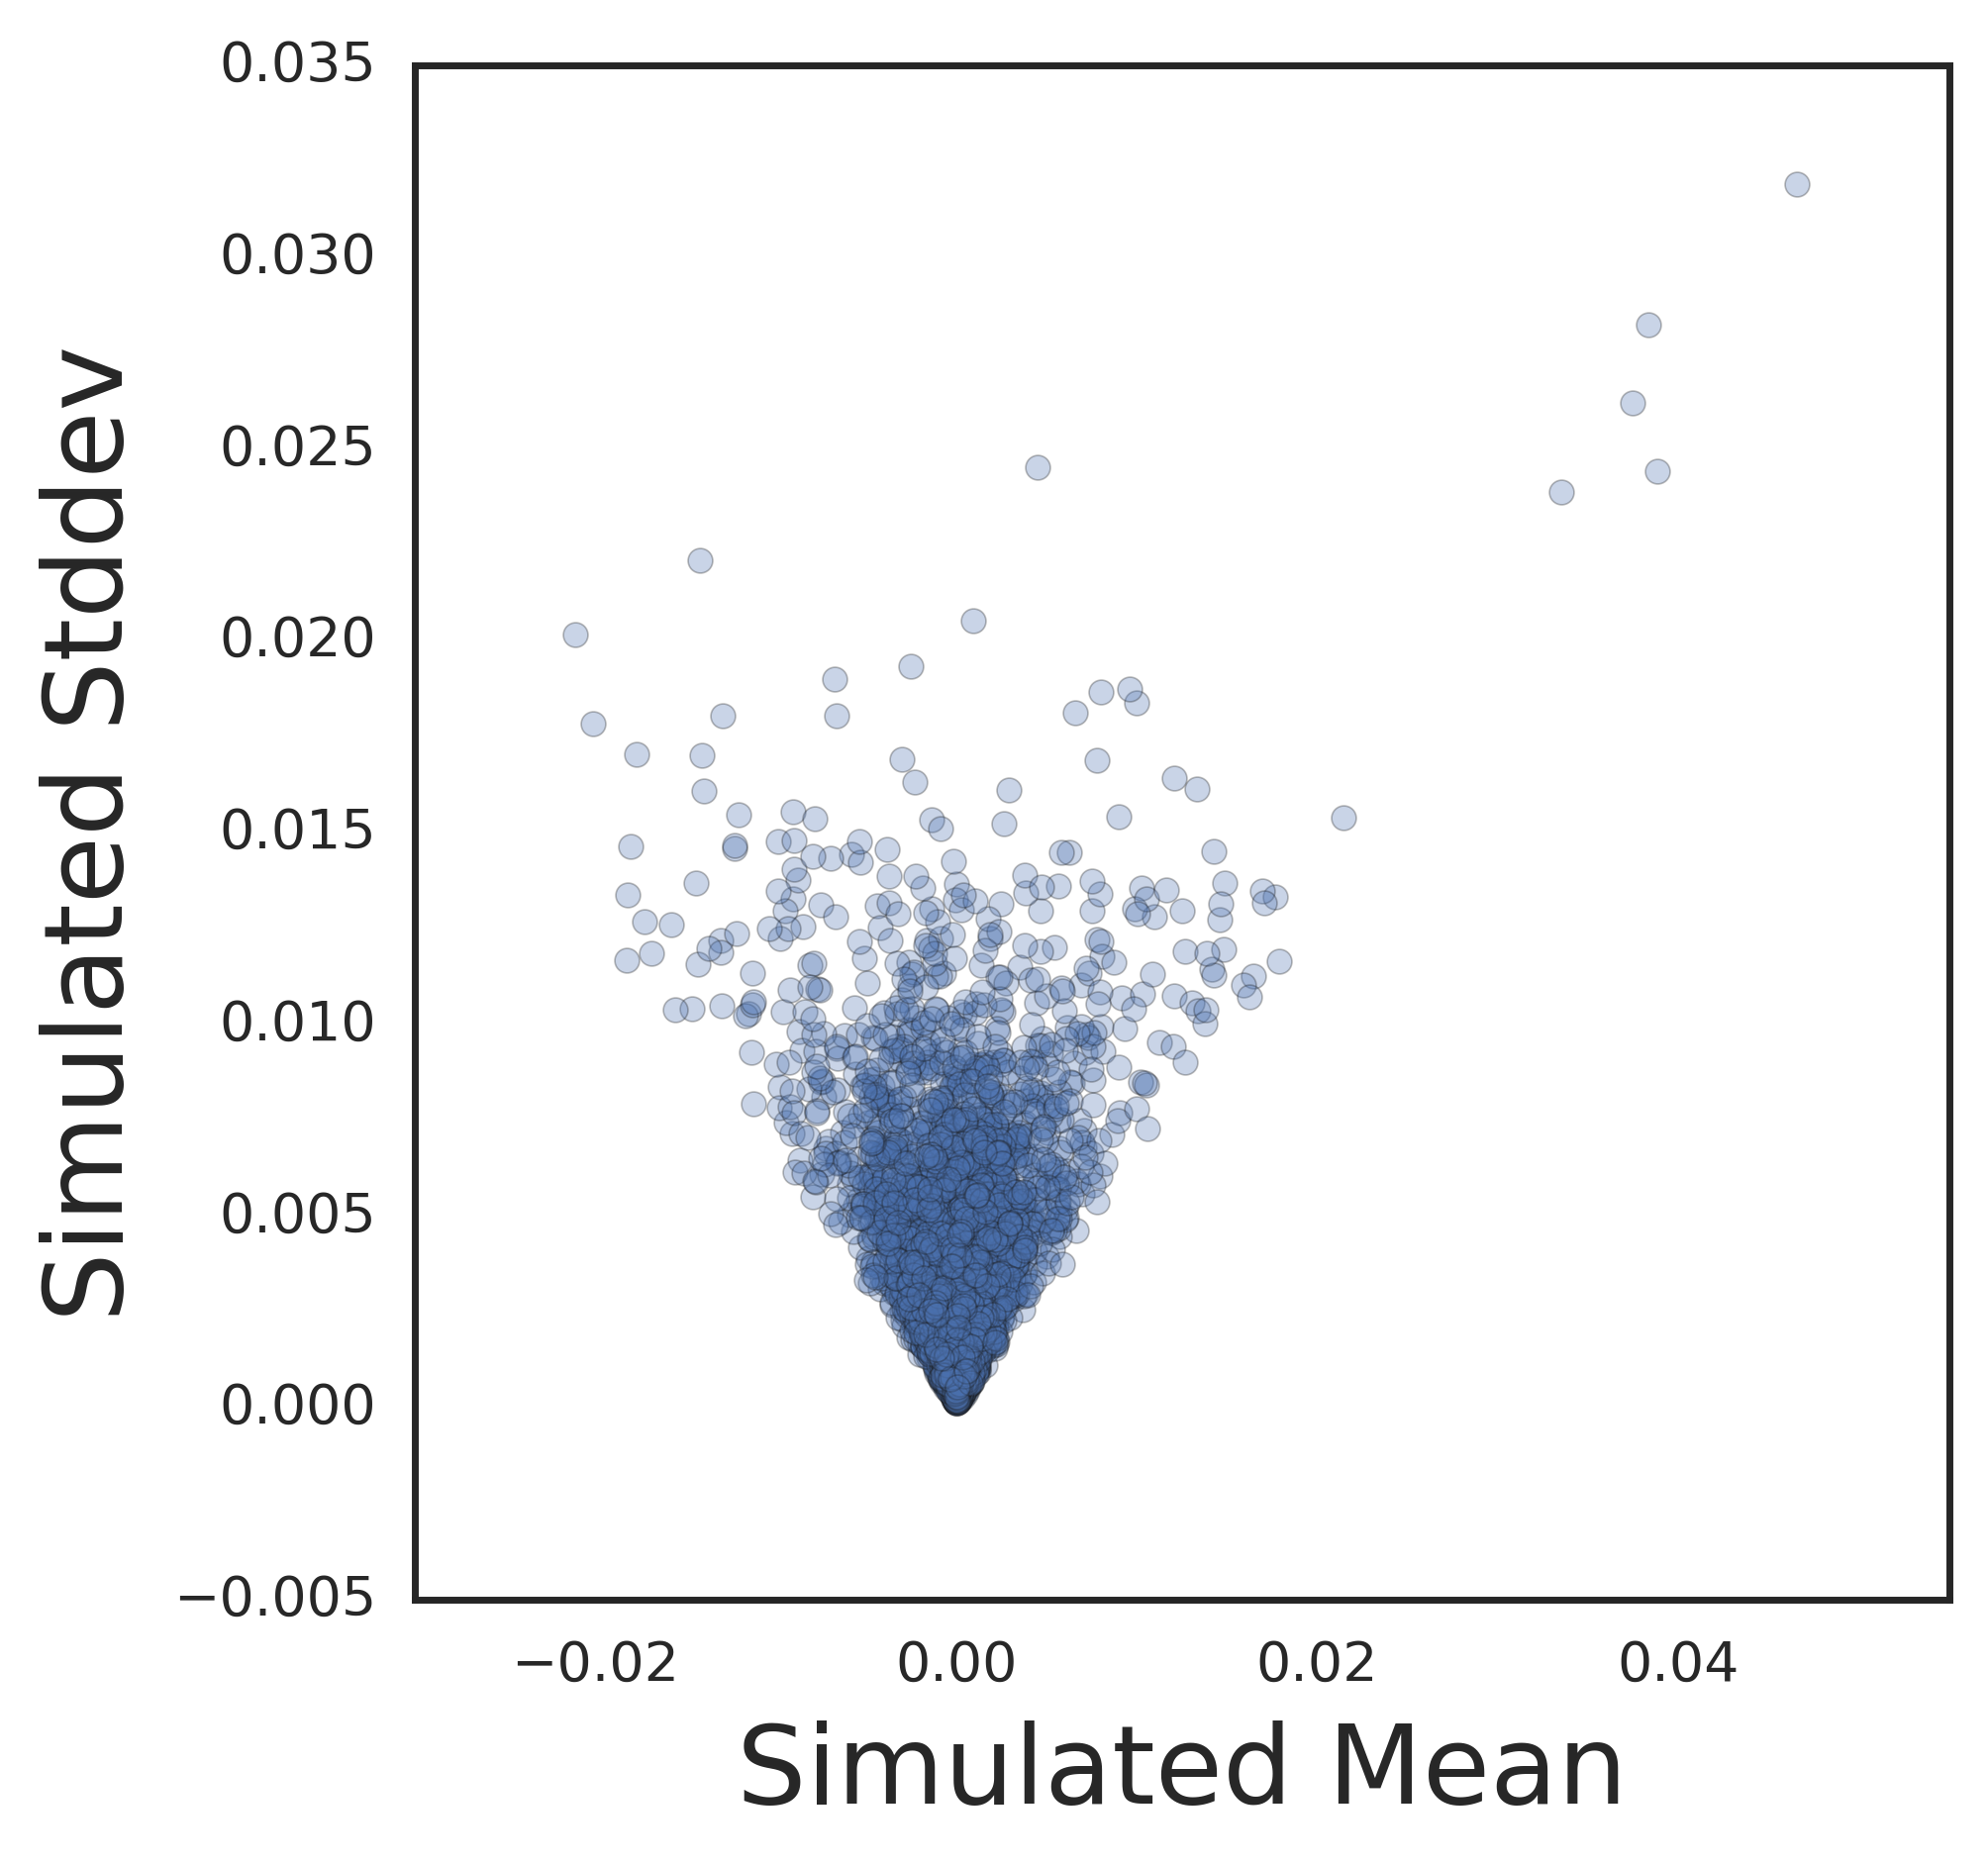

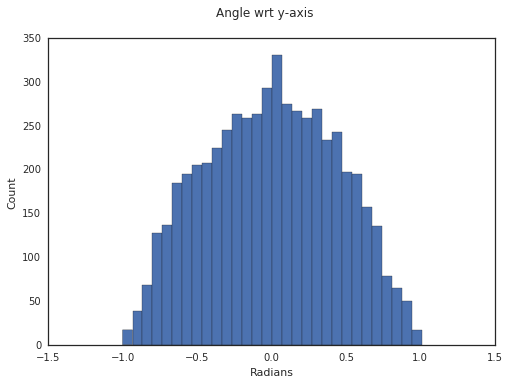

In [27]:
add_noise_for_seed(0, 2400, 1024, 0.4, 0.4)

In [56]:
def get_train_grad_loss_vals(seeds, idx):
    seed = seeds[-1]
    num_seeds = len(seeds)
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seed, num_units=num_units, num_steps=num_steps)
    f = np.load('../{}/{}_{}-seed_{}_train_grad_loss_vals.npz'.format(out,model_name,num_seeds,idx))
    return f['train_grad_loss_vals']

point = 1173#0#1173
jagged_train_grad_loss_vals = get_train_grad_loss_vals(seeds,point)
train_grad_loss_vals = [None] * num_seeds
for i in range(num_seeds):
    train_grad_loss_vals[i] = []
    for arr in jagged_train_grad_loss_vals[i]:
        train_grad_loss_vals[i] = list(train_grad_loss_vals[i]) + list(arr)
train_grad_loss_vals = np.array(train_grad_loss_vals)

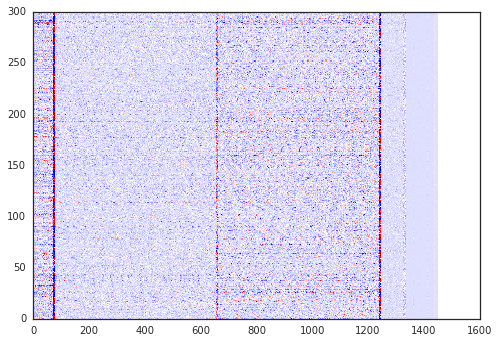

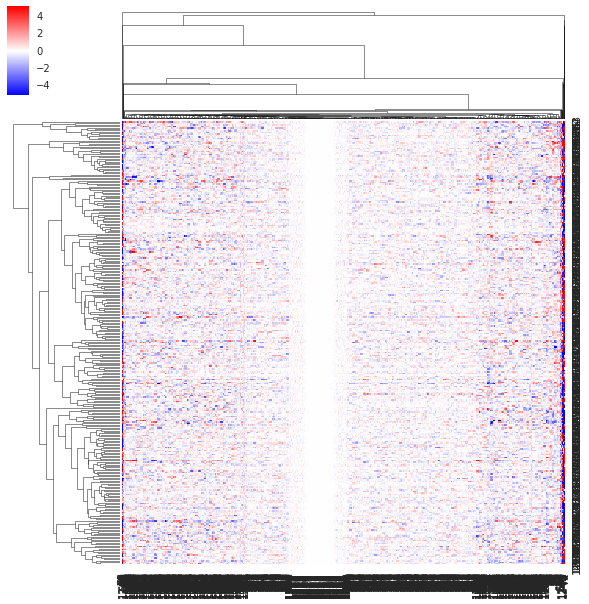

In [59]:
plt.pcolormesh(train_grad_loss_vals,cmap=plt.cm.bwr,norm=colors.Normalize(train_grad_loss_vals.min()/25,train_grad_loss_vals.max()/25))
plt.show()
g = sns.clustermap(train_grad_loss_vals,method='complete',cmap='bwr',vmin=train_grad_loss_vals.min()/25,vmax=train_grad_loss_vals.max()/25)

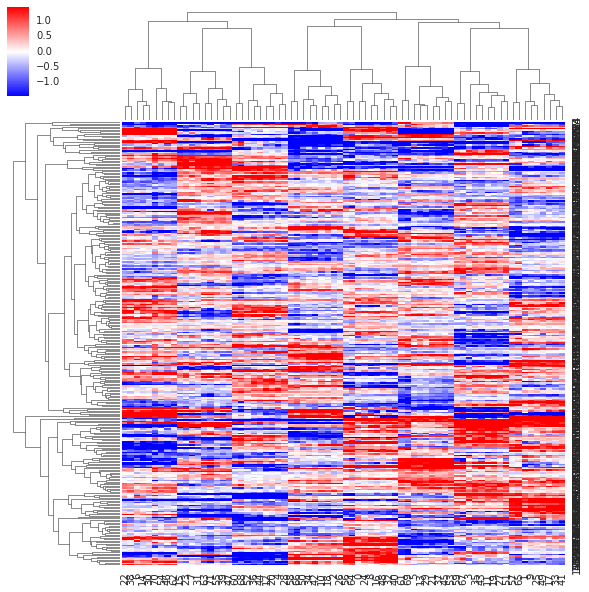

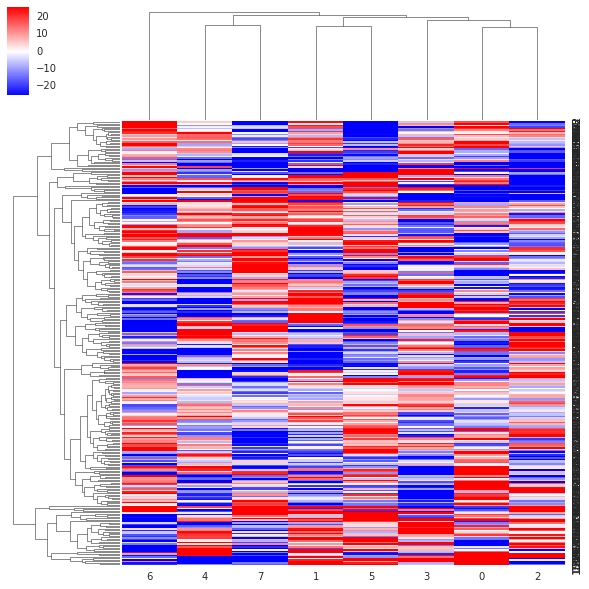

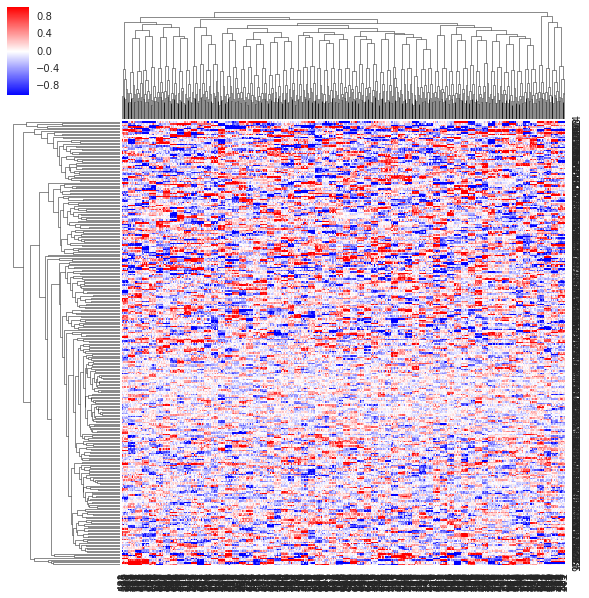

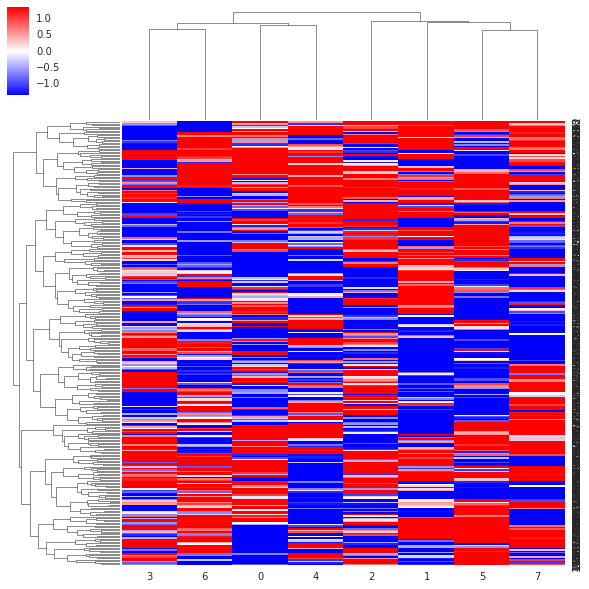

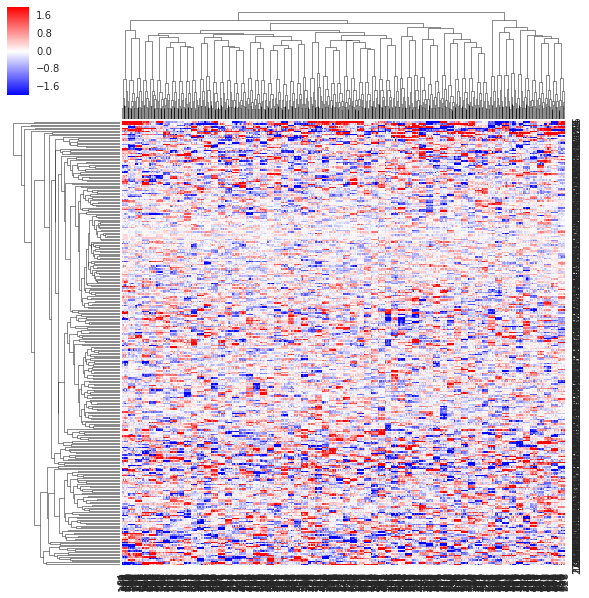

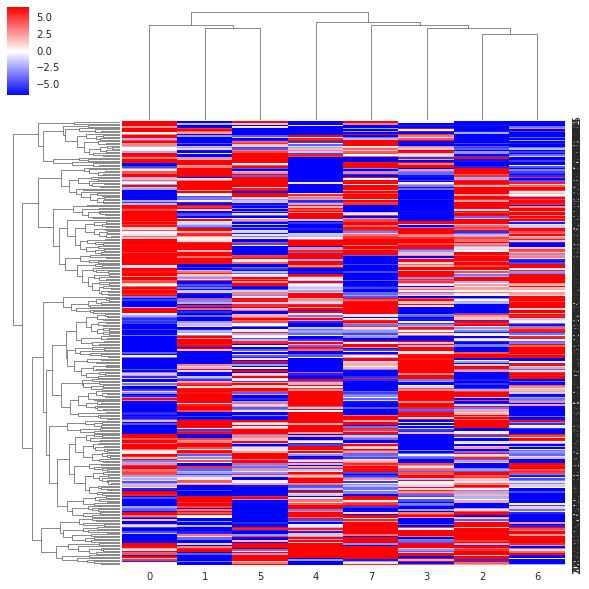

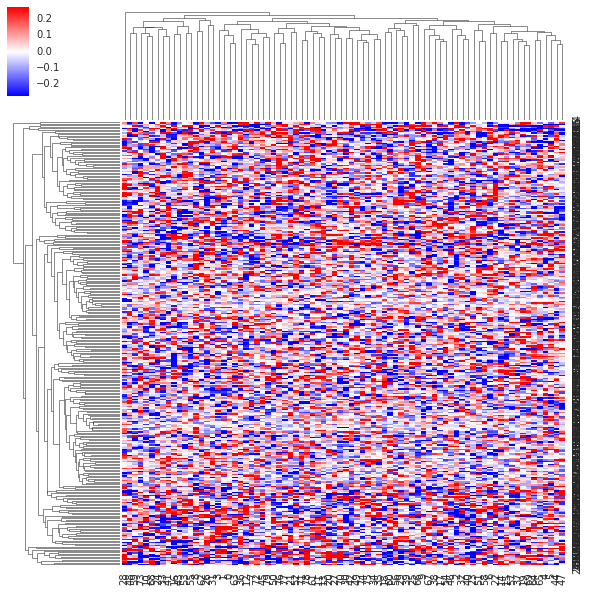

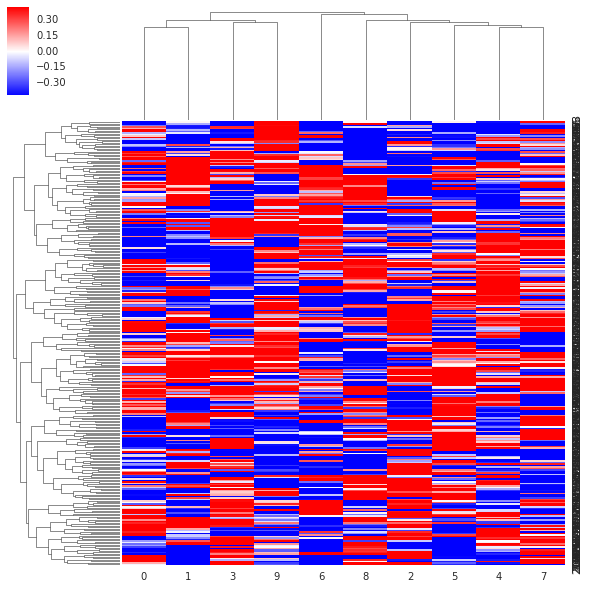

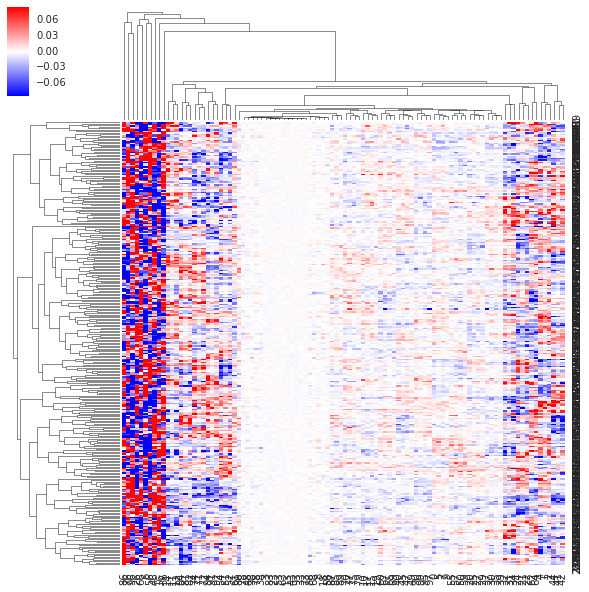

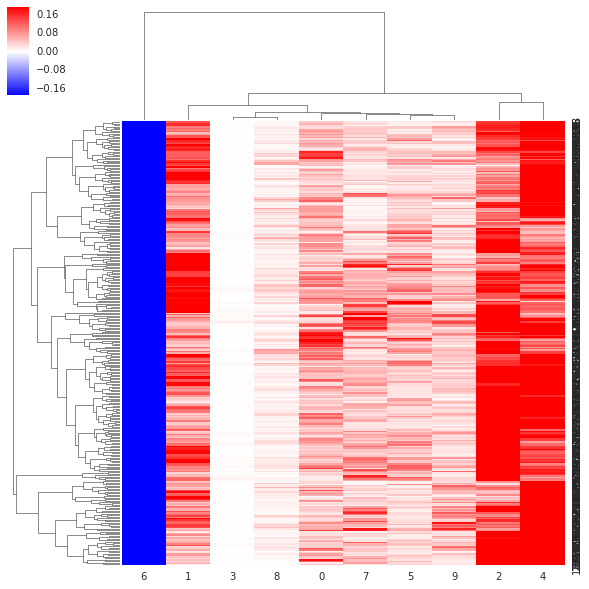

In [76]:
rng = 0
np.random.seed(rng)
base_seed = 0
divides = [0]
for num in [72,8,576,8,576,8,80,10,100,10]:
    divides.append(divides[-1]+num)
for partition in range(10):
    data = train_grad_loss_vals[:,divides[partition]:divides[partition+1]]
    g = sns.clustermap(data,method='complete',cmap='bwr',vmin=data.min()/5,vmax=data.max()/5)

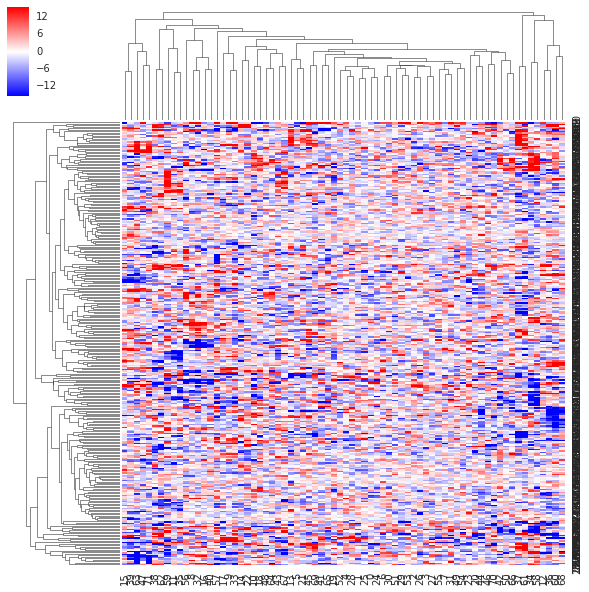

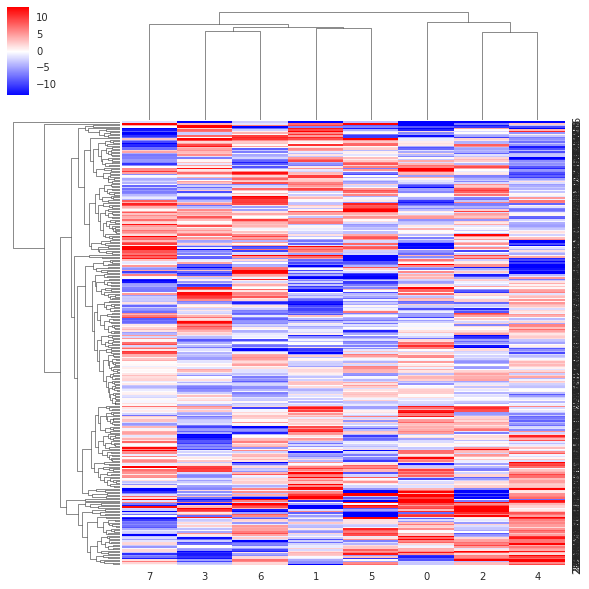

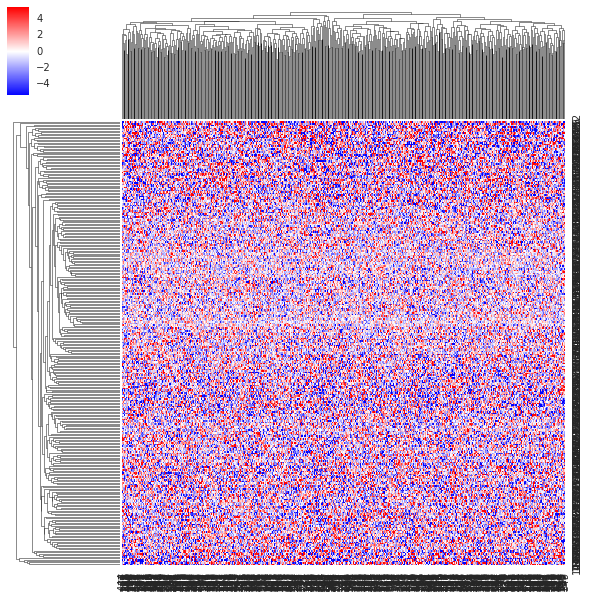

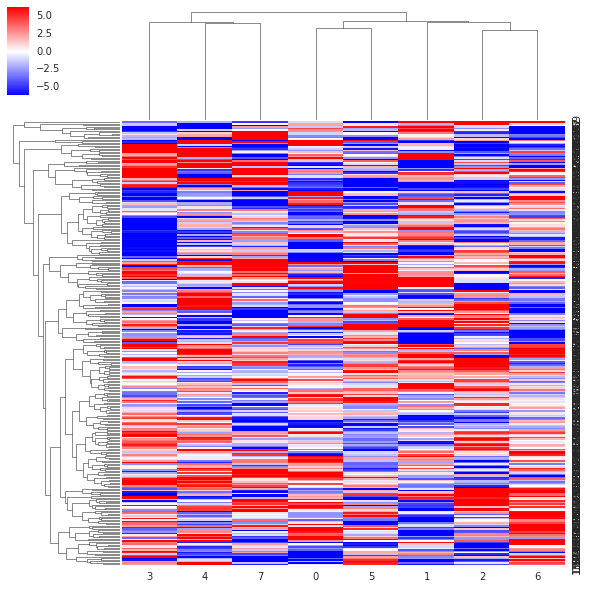

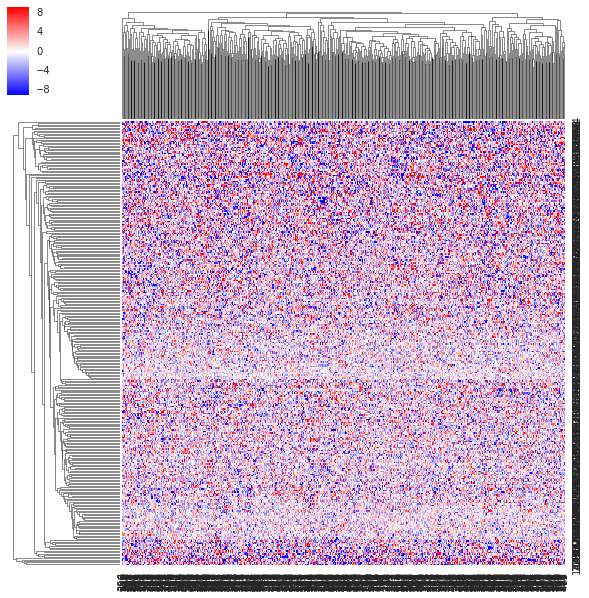

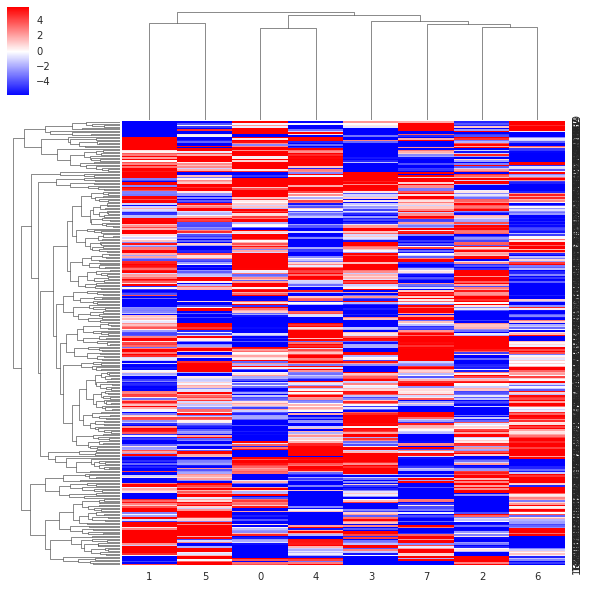

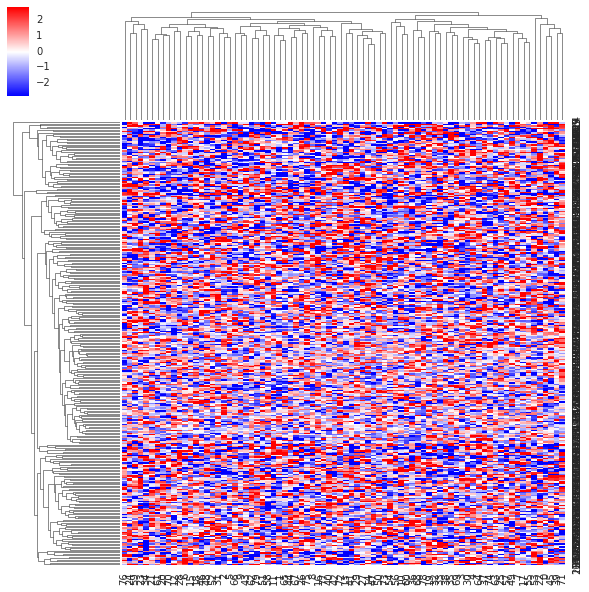

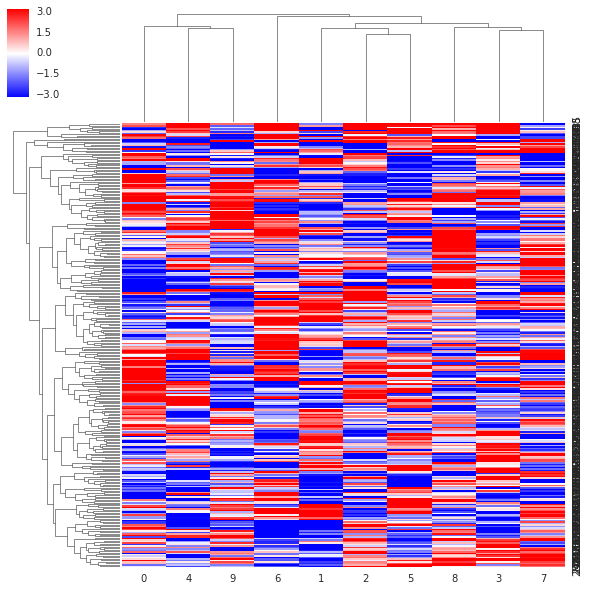

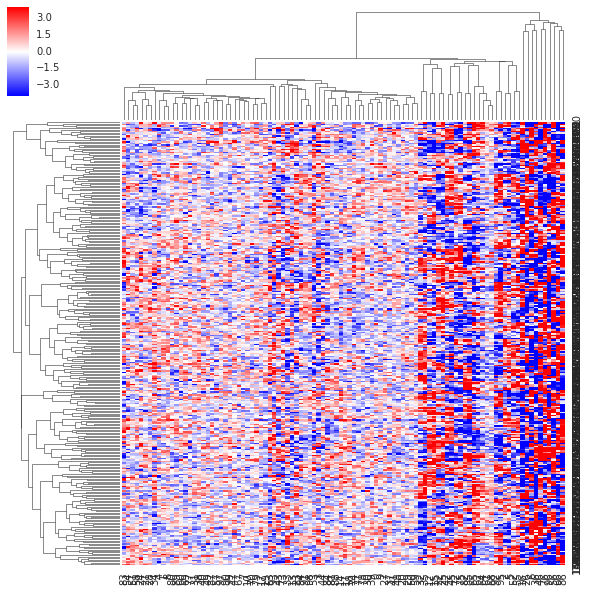

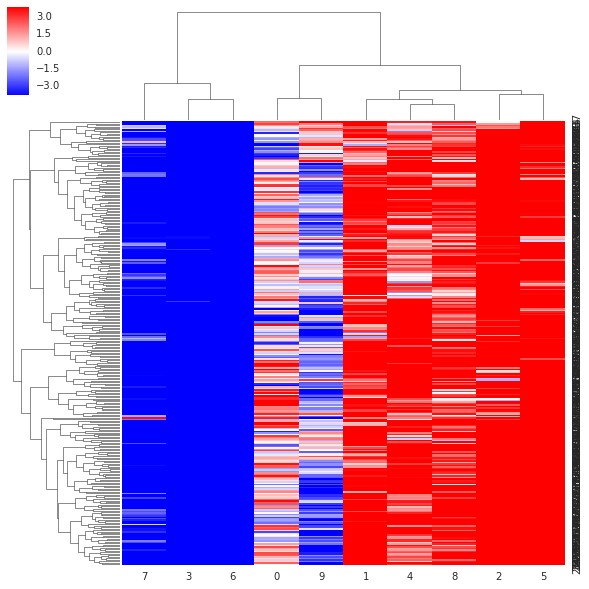

In [77]:
for partition in range(10):
    data = inverse_hvps[:,divides[partition]:divides[partition+1]]
    g = sns.clustermap(data,method='complete',cmap='bwr',vmin=data.min()/5,vmax=data.max()/5)

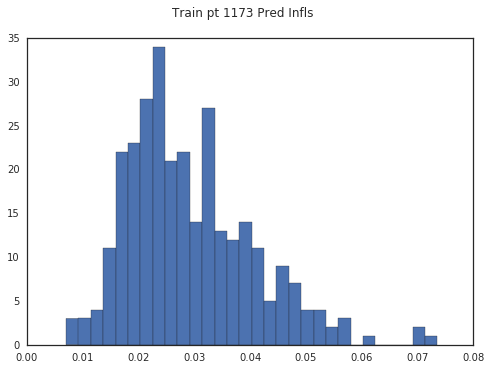

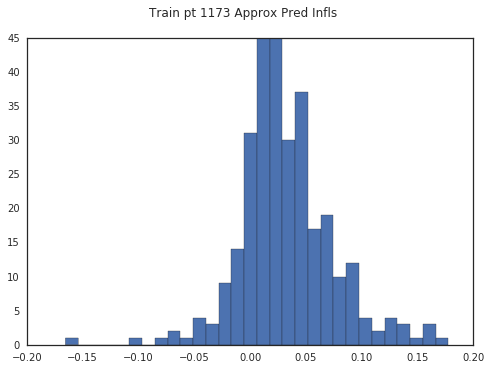

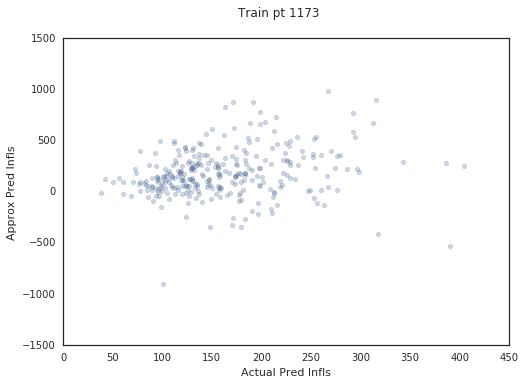

In [60]:
pred_infls = [np.dot(inverse_hvps[i], train_grad_loss_vals[i]) for i in range(num_seeds)]
plt.hist(np.divide(pred_infls,5500), bins=30)
plt.suptitle('Train pt {} Pred Infls'.format(point))
plt.show()

big_indices = range(72,80) + range(1240,1248)
approx_pred_infls = [np.dot(inverse_hvps[i][big_indices], train_grad_loss_vals[i][big_indices]) for i in range(num_seeds)]
plt.hist(np.divide(approx_pred_infls,5500), bins=30)
plt.suptitle('Train pt {} Approx Pred Infls'.format(point))
plt.show()

plt.scatter(pred_infls, approx_pred_infls,alpha=0.3)
plt.xlabel('Actual Pred Infls')
plt.ylabel('Approx Pred Infls')
plt.suptitle('Train pt {}'.format(point))
plt.show()

(array([  74,   76,   77,   78, 1240, 1241, 1247]),)


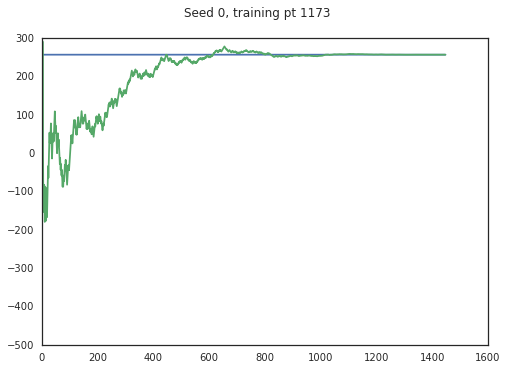

(array([  72,   73,   74,   75,   78,   79, 1241]),)


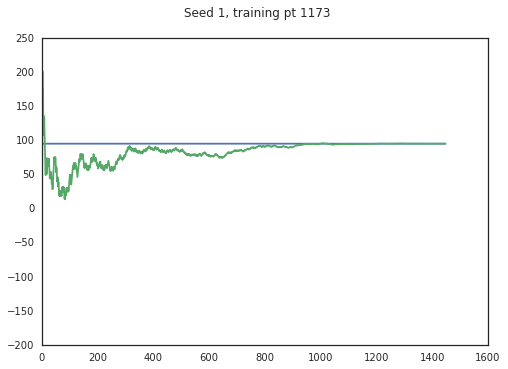

(array([  72,   75,   76,   77,   78,   79, 1242, 1245]),)


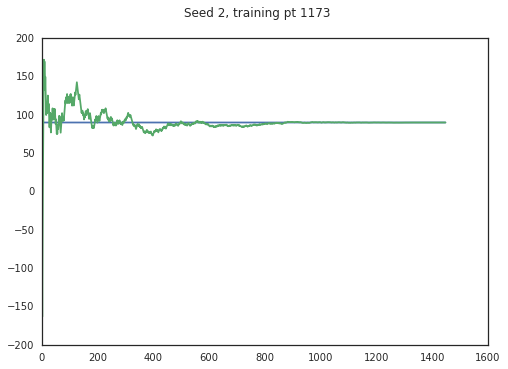

(array([  72,   73,   78, 1244, 1245, 1246]),)


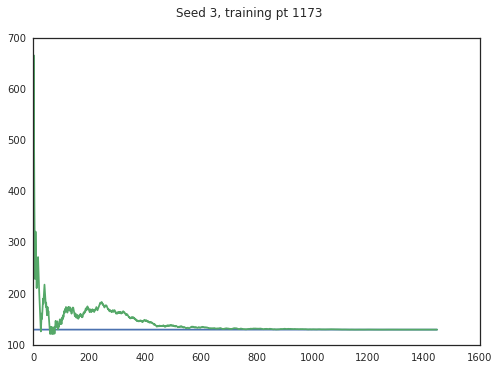

(array([  72,   73,   75,   77,  989, 1244, 1245]),)


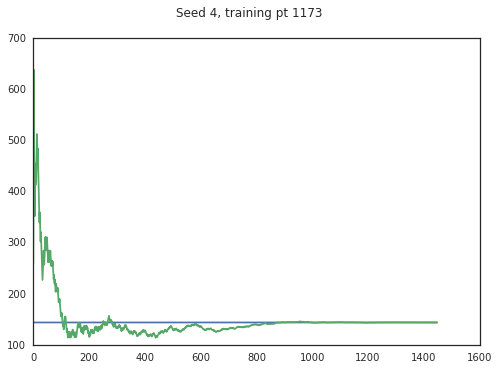

(array([  73,   78, 1246, 1247]),)


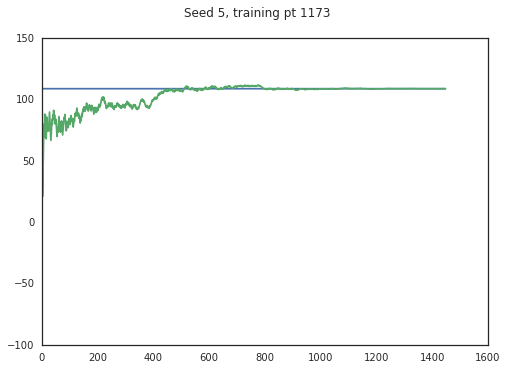

(array([  74,   78,   79,  658, 1245, 1246]),)


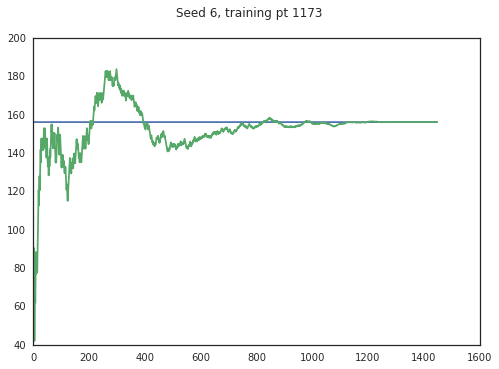

(array([  56,   74,   75,   77,   78,  232,  272,  296,  312,  359,  360,
        423,  511,  519,  616,  623,  632,  647,  658,  733,  735,  797,
        799,  991, 1085, 1154, 1183, 1210, 1241, 1242, 1243, 1244, 1444]),)


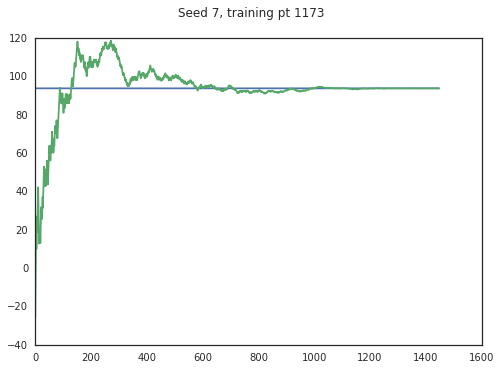

(array([  72,   74,   75,   76, 1242, 1243]),)


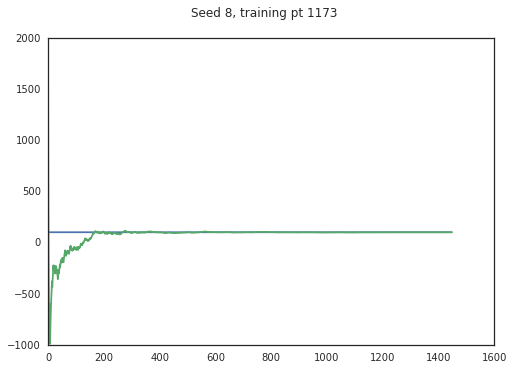

(array([  61,   72,   73,   75,   76, 1241, 1243, 1246]),)


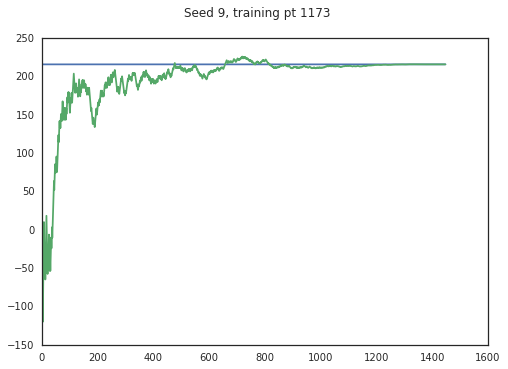

(array([  73,   75,   76, 1241]),)


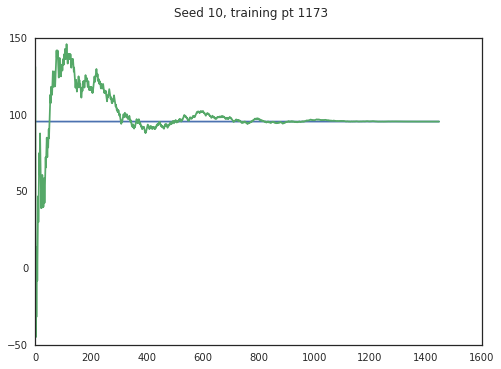

(array([  75,   77,   78, 1245]),)


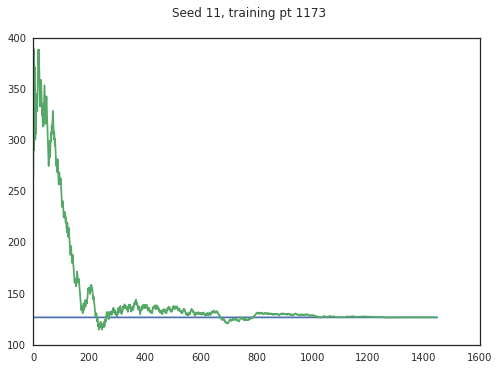

(array([  72,   73,   74,   75,   77,   79,   88,  248,  313,  488,  505,
        568,  616,  659,  820,  976, 1012, 1032, 1036, 1044, 1168, 1172,
       1192, 1196, 1204, 1224, 1240, 1241, 1242, 1243, 1244, 1245]),)


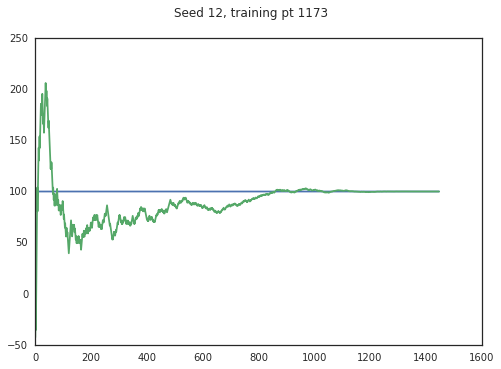

(array([  72,   75,   76,   78, 1242]),)


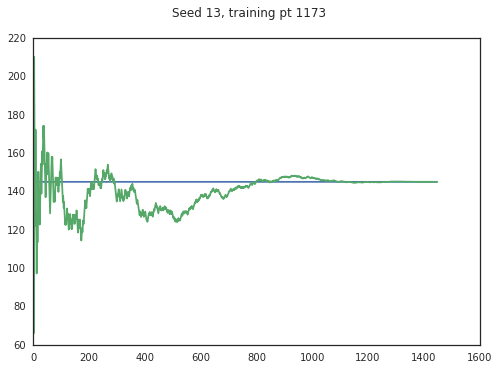

(array([  72,   73,   75,   79, 1097, 1240, 1241, 1242, 1244]),)


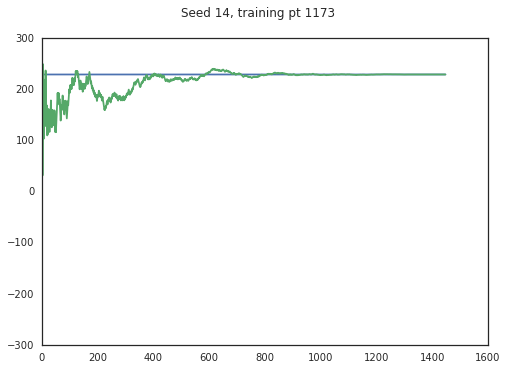

(array([  73,   74,   77,   78,   79, 1242]),)


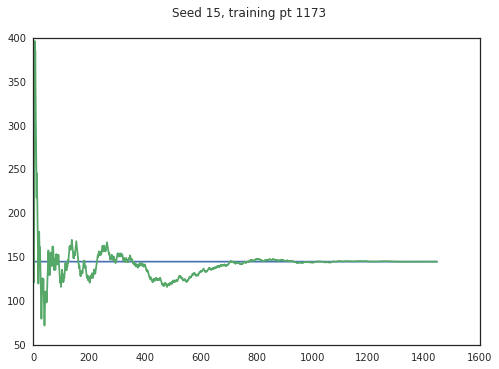

(array([  73,   74,   75,   76,   77,   78,   79,  660, 1136, 1240, 1246]),)


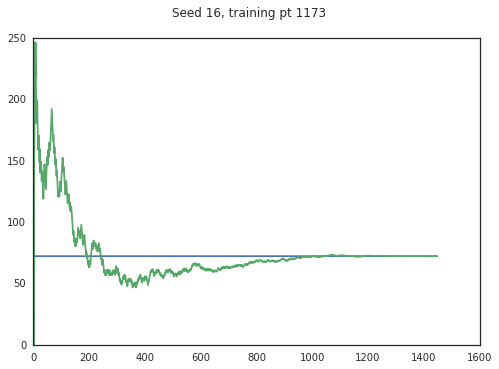

(array([76, 77, 79]),)


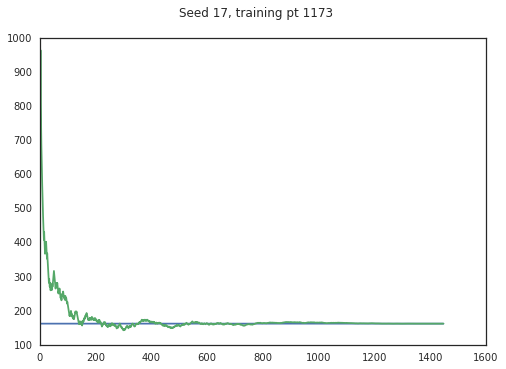

(array([  72,   74,   75,   76,   77,   79,  656,  660,  918,  993,  998,
       1008, 1030, 1057, 1121, 1129, 1136, 1177, 1185, 1240, 1241, 1242,
       1243, 1246, 1247]),)


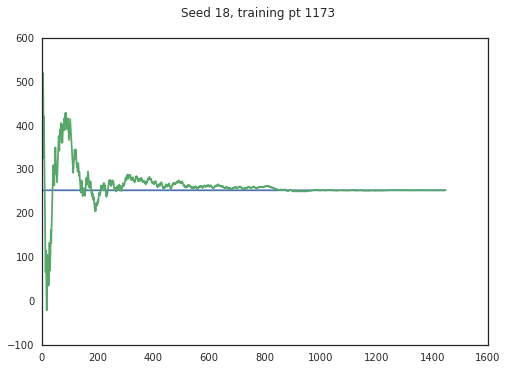

(array([  76,   77,   78, 1240]),)


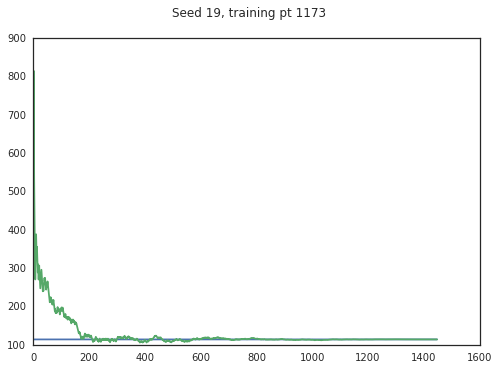

(array([  72,   73,   75,   76,   77,   78,  449,  601,  656,  971, 1240,
       1247]),)


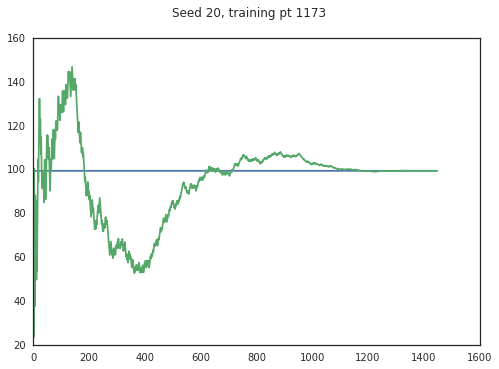

(array([72, 73, 76, 79]),)


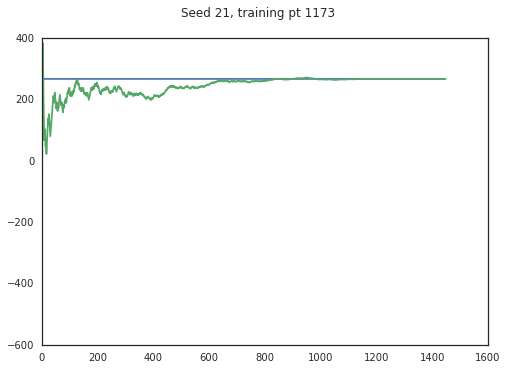

(array([74, 77, 79]),)


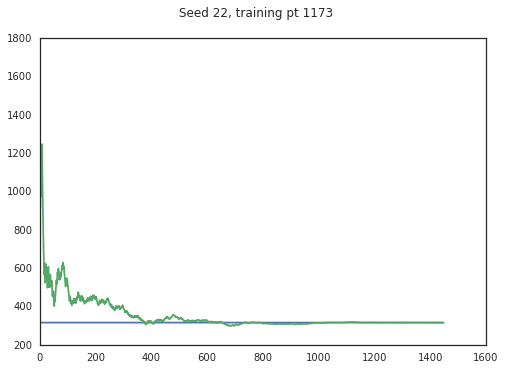

(array([72, 74, 76, 77, 79]),)


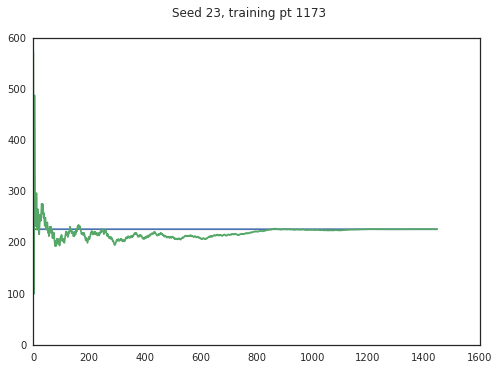

(array([  73,   74,   75,   77, 1241, 1242, 1243, 1245]),)


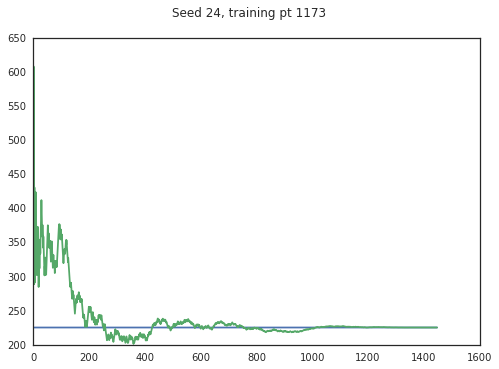

In [58]:
num_params = len(inverse_hvps[0])
def compare_magnitudes(i):
    arr = np.multiply(inverse_hvps[i],train_grad_loss_vals[i])
    #plt.scatter(range(num_params),arr,alpha=0.3)
    #plt.show()
    print(np.where(np.abs(arr)>np.abs(arr).max()/5))
    sorted_arr = np.sort(np.abs(arr))
    #plt.scatter(range(num_params),sorted_arr)
    #plt.show()
    abs_sums = np.zeros(num_params)
    abs_sums[0] = sorted_arr[0]
    for j in range(0,num_params):
        abs_sums[j] = abs_sums[j-1] + sorted_arr[j]
    #plt.scatter(range(num_params),abs_sums)
    #plt.show()
    
    sorted_indices = np.argsort(np.abs(arr))
    sums = np.zeros(num_params)
    sums[0] = arr[sorted_indices[-1]]
    for j in range(0, num_params):
        sums[j] = sums[j-1] + arr[sorted_indices[-(j+1)]]
    #plt.scatter(range(num_params),sums,alpha=0.3)
    plt.plot([pred_infls[i]]*num_params)
    plt.plot(sums)
    plt.suptitle('Seed {}, training pt {}'.format(i, point))
    plt.show()
for i in range(25):
    compare_magnitudes(i)

In [ ]:
def get_params(seeds):
    seed = seeds[-1]
    num_seeds = len(seeds)
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seed, num_units=num_units, num_steps=num_steps)
    f = np.load('../{}/{}_{}-seed_all_params.npz'.format(out,model_name,num_seeds))
    return f['params']

params = []
if dataset_type == 'cifar10':
    params = list(params) + list(get_params(range(0,6)))
    params = list(params) + list(get_params(range(6,12)))
    params = list(params) + list(get_params(range(12,18)))
    params = list(params) + list(get_params(range(18,24)))
elif dataset_type == 'mnist_small':
    params = list(params) + list(get_params(range(300)))

In [ ]:
flat_params = [None] * num_seeds
for i, p in enumerate(params):
    a = []
    for q in p:
        a = a + list(q)
    flat_params[i] = a
flat_params = np.array(flat_params)

In [ ]:
plt.pcolormesh(flat_params,cmap=plt.cm.bwr,norm=colors.Normalize(flat_params.min(),flat_params.max()))
plt.show()

In [ ]:
g = sns.clustermap(flat_params,cmap='bwr',vmin=flat_params.min(),vmax=flat_params.max())